In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# **Visualize turn**

In [54]:
inner = 40
width = 6
outer = inner + width
n = 25

rin = np.zeros(n)
rout = np.zeros(n)

theta = np.linspace(0, np.pi/2, n, endpoint=True)

rin[0:int(n/2)] = inner/np.cos(theta[:int(n/2)])
rin[int(n/2):] = inner/np.sin(theta[int(n/2):])

rout[0:int(n/2)] = outer/np.cos(theta[:int(n/2)])
rout[int(n/2):] = outer/np.sin(theta[int(n/2):])

r = (0.5*rin + 0.5*rout)

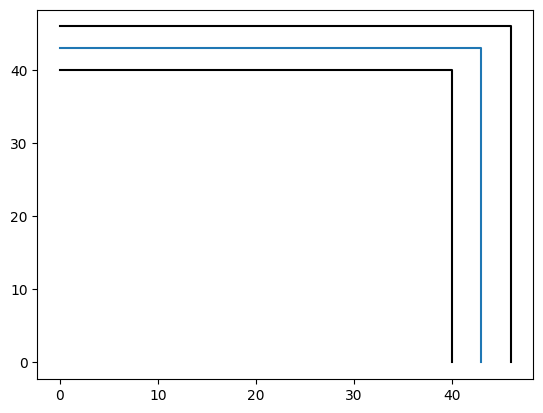

In [55]:
plt.plot(rin*np.cos(theta), rin*np.sin(theta), color='black')
plt.plot(rout*np.cos(theta), rout*np.sin(theta), color='black')
plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.show()

# **Optimize radius of curvature for minimum tire wear with vanilla gradient descent**

In [56]:
def get_radius_curvature(r, theta):
  r_curv = torch.zeros(len(r))
  for i in range(1, len(r)-1):
    drdtheta = (r[i+1]-r[i-1])/(theta[i+1]-theta[i-1])
    d2rdtheta2 =  (r[i+1]-2*r[i]+r[i-1])/((theta[i+1]-theta[i-1])/2)**2
    r_curv[i] = (r[i]**2+drdtheta**2)**(3/2) / torch.abs(r[i]**2 + 2*drdtheta**2 - r[i]*d2rdtheta2)

  return torch.min(r_curv[1:-1])

In [57]:
lr = 0.01
iterations = 500

In [58]:
theta = torch.tensor(theta, requires_grad=False)
r = (0.5*rin + 0.5*rout)

r = torch.tensor(r, requires_grad=True)
r_all = np.zeros((iterations, len(theta)))
r_curve_all = np.zeros(iterations)

r_all[0] = r.clone().detach()

for i in range(iterations-1):
    r_curv = get_radius_curvature(r, theta)
    r_curv.backward()
    grad = r.grad
    r_new = r + lr*grad
    
    r_all[i+1] = r_new.clone().detach().numpy()
    
    r_all[i+1][np.any(r_all[i+1]>rout)] = rout[np.any(r_all[i+1]>rout)]
    r_all[i+1][np.any(r_all[i+1]<rin)] = rin[np.any(r_all[i+1]<rin)]

    r_curve_all[i] = r_curv.detach().clone()
    
    r = torch.tensor(r_all[i+1], requires_grad=True)

r_curve_all[-1] = get_radius_curvature(r, theta).detach().clone()

In [59]:
theta = theta.clone().detach().numpy()

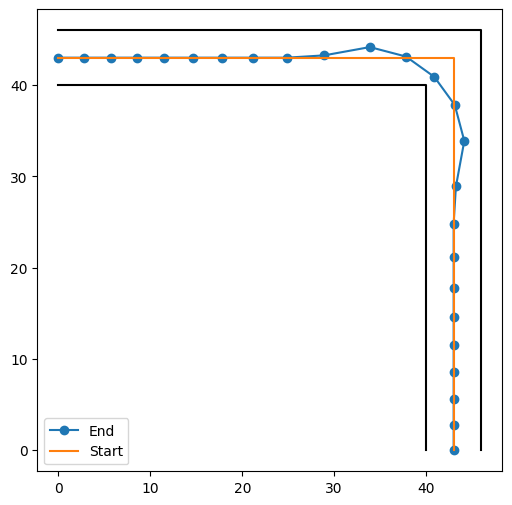

In [60]:
i = -1
plt.figure(figsize=(6,6))
plt.plot(r_all[i]*np.cos(theta), r_all[i]*np.sin(theta), 'o-', label='End')
plt.plot(r_all[0]*np.cos(theta), r_all[0]*np.sin(theta), '-', label='Start')
plt.plot(rin*np.cos(theta), rin*np.sin(theta), color='black')
plt.plot(rout*np.cos(theta), rout*np.sin(theta), color='black')
plt.legend()
plt.show()

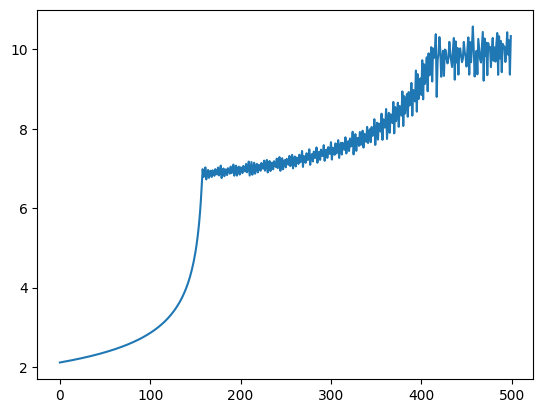

In [61]:
plt.plot(r_curve_all)
plt.show()

In [62]:
np.savetxt('path_all_plain.txt', r_all)
np.savetxt('curv_all_plain.txt', r_curve_all)

# **Optimize radius of curvature for minimum tire wear with gradient descent with momentum**

In [63]:
theta = torch.tensor(theta, requires_grad=False)
r = (0.5*rin + 0.5*rout)

r = torch.tensor(r, requires_grad=True)
r_all = np.zeros((iterations, len(theta)))
r_curve_all = np.zeros(iterations)

r_all[0] = r.clone().detach()

velocity = torch.zeros_like(r)  # Initialize the velocity to zeros

momentum = 0.9

for i in range(iterations-1):
    r_curv = get_radius_curvature(r, theta)
    r_curv.backward()
    grad = r.grad

    # Update velocity with momentum
    velocity = momentum * velocity + (1 - momentum) * grad
    
    r_new = r + lr*velocity  # Update r with the momentum-boosted gradient
    
    r_all[i+1] = r_new.clone().detach().numpy()
    
    r_all[i+1][np.any(r_all[i+1]>rout)] = rout[np.any(r_all[i+1]>rout)]
    r_all[i+1][np.any(r_all[i+1]<rin)] = rin[np.any(r_all[i+1]<rin)]

    r_curve_all[i] = r_curv.detach().clone()
    
    r = torch.tensor(r_all[i+1], requires_grad=True)

    r.grad = None # Reset gradient to zero for the next iteration

r_curve_all[-1] = get_radius_curvature(r, theta).detach().clone()

In [64]:
theta = theta.clone().detach().numpy()

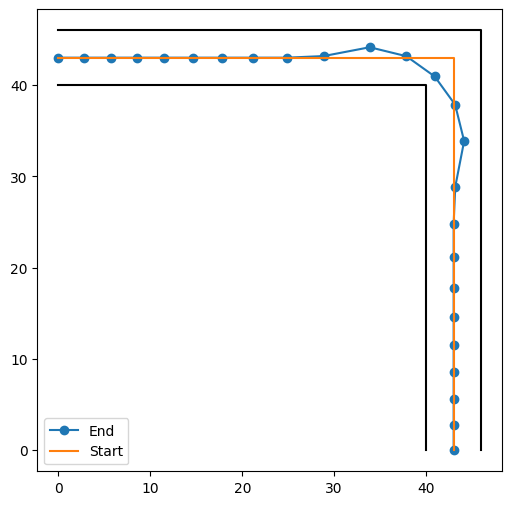

In [65]:
i = -1
plt.figure(figsize=(6,6))
plt.plot(r_all[i]*np.cos(theta), r_all[i]*np.sin(theta), 'o-', label='End')
plt.plot(r_all[0]*np.cos(theta), r_all[0]*np.sin(theta), '-', label='Start')
plt.plot(rin*np.cos(theta), rin*np.sin(theta), color='black')
plt.plot(rout*np.cos(theta), rout*np.sin(theta), color='black')
plt.legend()
plt.show()

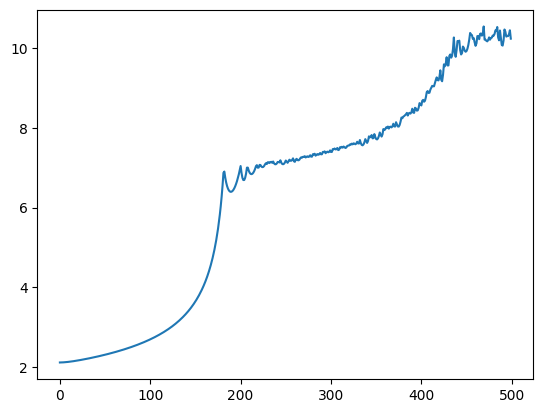

In [66]:
plt.plot(r_curve_all)
plt.show()

In [67]:
np.savetxt('path_all_momentum.txt', r_all)
np.savetxt('curv_all_momentum.txt', r_curve_all)

# **Optimizing time with vanilla gradient descent**

In [68]:
def get_time(r, theta):
  r_curv = torch.zeros(len(r))
  path_length = 0
  for i in range(1, len(r)-1):
    drdtheta = (r[i+1]-r[i-1])/(theta[i+1]-theta[i-1])
    d2rdtheta2 =  (r[i+1]-2*r[i]+r[i-1])/((theta[i+1]-theta[i-1])/2)**2
    r_curv[i] = (r[i]**2+drdtheta**2)**(3/2) / torch.abs(r[i]**2 + 2*drdtheta**2 - r[i]*d2rdtheta2)

    xin, yin = r[i]*torch.cos(theta[i]), r[i]*torch.sin(theta[i])
    xfin, yfin = r[i+1]*torch.cos(theta[i+1]), r[i+1]*torch.sin(theta[i+1])
    path_length += torch.sqrt((xin-xfin)**2 + (yin-yfin)**2)

  v = torch.sqrt(0.17*9.81*torch.min(r_curv[1:-1]))

  return path_length/v

In [69]:
lr = 0.01
iterations = 500

theta = torch.tensor(theta, requires_grad=False)
r = (0.5*rin + 0.5*rout)

r = torch.tensor(r, requires_grad=True)
r_all = np.zeros((iterations, len(theta)))
times_all = np.zeros(iterations)

r_all[0] = r.clone().detach()

for i in range(iterations-1):
    time = get_time(r, theta)
    time.backward()
    grad = r.grad
    r_new = r - lr*grad
    
    r_all[i+1] = r_new.clone().detach().numpy()
    
    r_all[i+1][np.any(r_all[i+1]>rout)] = rout[np.any(r_all[i+1]>rout)]
    r_all[i+1][np.any(r_all[i+1]<rin)] = rin[np.any(r_all[i+1]<rin)]

    times_all[i] = time.detach().clone()
    
    r = torch.tensor(r_all[i+1], requires_grad=True)

times_all[-1] = get_time(r, theta).detach().clone()

In [70]:
theta = theta.clone().detach().numpy()

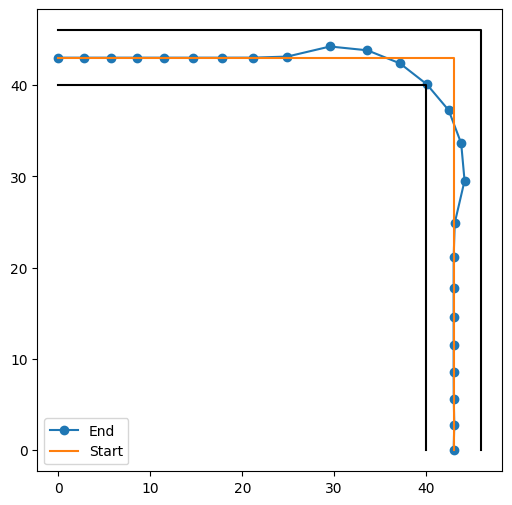

In [71]:
i = -1
plt.figure(figsize=(6,6))
plt.plot(r_all[i]*np.cos(theta), r_all[i]*np.sin(theta), 'o-', label='End')
plt.plot(r_all[0]*np.cos(theta), r_all[0]*np.sin(theta), '-', label='Start')
plt.plot(rin*np.cos(theta), rin*np.sin(theta), color='black')
plt.plot(rout*np.cos(theta), rout*np.sin(theta), color='black')
plt.legend()
plt.show()

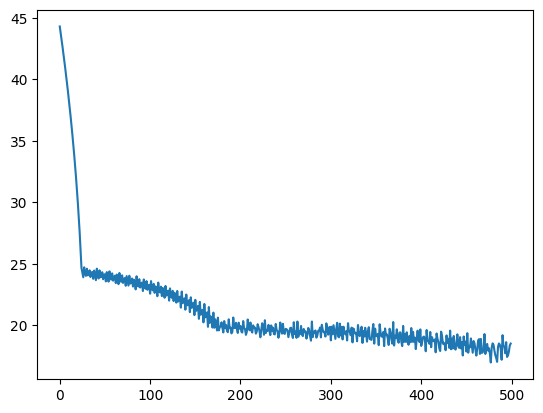

In [72]:
plt.plot(times_all)
plt.show()

In [73]:
np.savetxt('path_all_times_plain.txt', r_all)
np.savetxt('times_plain.txt', times_all)

# **Optimizing time with gradient descent with momentum**

In [74]:
lr = 0.01
momentum = 0.9
iterations = 500

theta = torch.tensor(theta, requires_grad=False)
r = (0.5*rin + 0.5*rout)

r = torch.tensor(r, requires_grad=True)
r_all = np.zeros((iterations, len(theta)))
times_all = np.zeros(iterations)

r_all[0] = r.clone().detach()
velocity = torch.zeros_like(r)  # Initialize the velocity to zeros

for i in range(iterations-1):
    time = get_time(r, theta)
    time.backward()
    grad = r.grad
    
    # Update velocity with momentum
    velocity = momentum * velocity + (1 - momentum) * grad
    
    r_new = r - lr*velocity  # Update r with the momentum-boosted gradient
    
    r_all[i+1] = r_new.clone().detach().numpy()
    
    r_all[i+1][np.any(r_all[i+1]>rout)] = rout[np.any(r_all[i+1]>rout)]
    r_all[i+1][np.any(r_all[i+1]<rin)] = rin[np.any(r_all[i+1]<rin)]

    times_all[i] = time.detach().clone()
    
    r = torch.tensor(r_all[i+1], requires_grad=True)
    r.grad = None  # Reset gradient to zero for the next iteration

times_all[-1] = get_time(r, theta).detach().clone()

In [75]:
theta = theta.clone().detach().numpy()

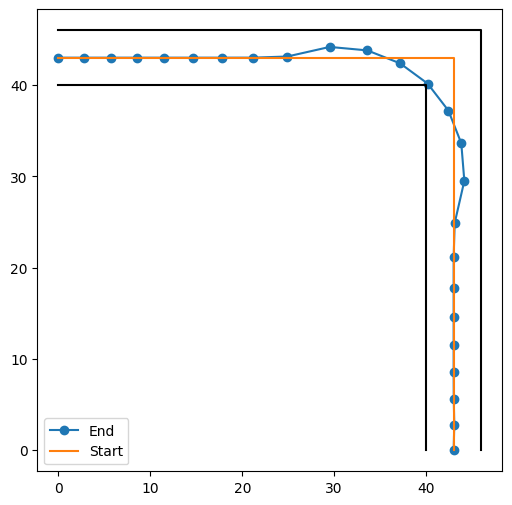

In [76]:
i = -1
plt.figure(figsize=(6,6))
plt.plot(r_all[i]*np.cos(theta), r_all[i]*np.sin(theta), 'o-', label='End')
plt.plot(r_all[0]*np.cos(theta), r_all[0]*np.sin(theta), '-', label='Start')
plt.plot(rin*np.cos(theta), rin*np.sin(theta), color='black')
plt.plot(rout*np.cos(theta), rout*np.sin(theta), color='black')
plt.legend()
plt.show()

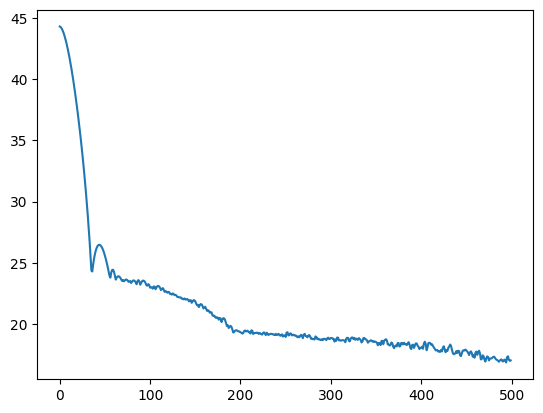

In [77]:
plt.plot(times_all)
plt.show()

In [78]:
np.savetxt('path_all_times_momentum.txt', r_all)
np.savetxt('times_momentum.txt', times_all)